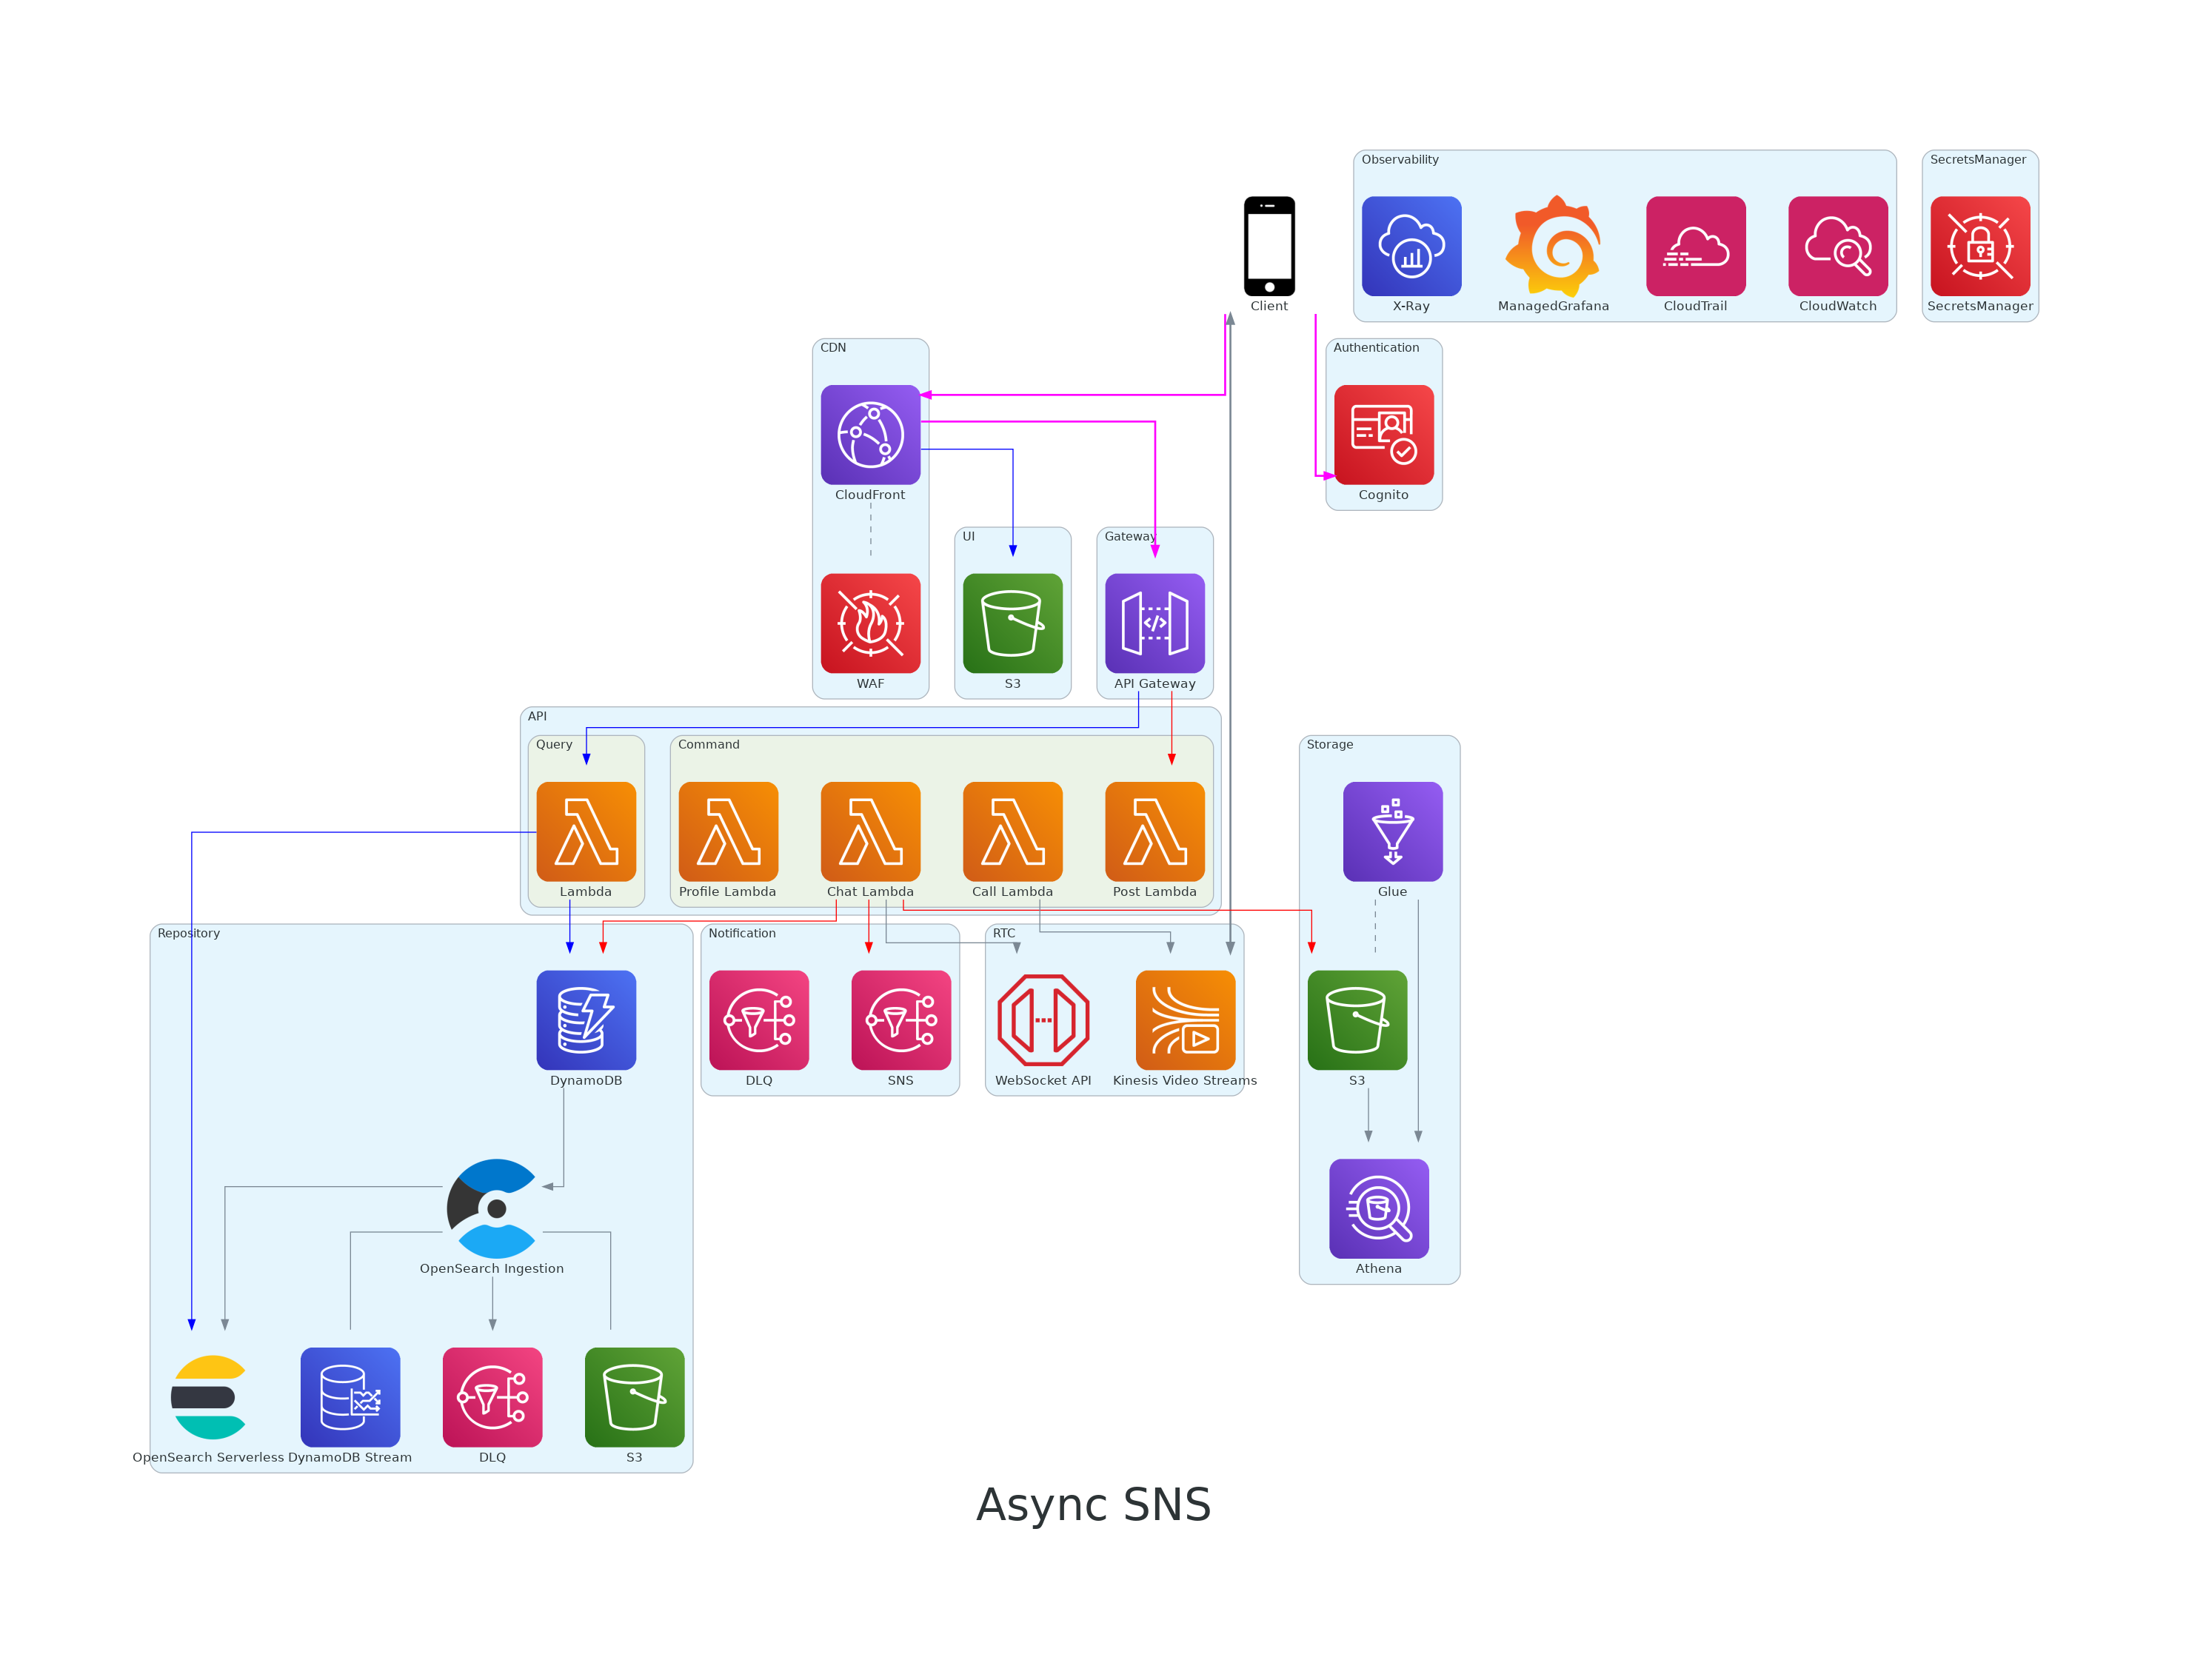

In [42]:
from diagrams import Diagram, Cluster, Edge
from diagrams.aws.security import Cognito, WAF
from diagrams.aws.network import APIGateway, CloudFront
from diagrams.aws.storage import S3
from diagrams.aws.database import Dynamodb
from diagrams.aws.analytics import KinesisDataStreams, Athena, Glue
from diagrams.aws.integration import SNS
from diagrams.aws.compute import Lambda
from diagrams.aws.database import Timestream
from diagrams.aws.management import Cloudwatch, Cloudtrail
from diagrams.aws.security import SecretsManager
from diagrams.aws.mobile import APIGatewayEndpoint
from diagrams.aws.media import KinesisVideoStreams
from diagrams.onprem.monitoring import Grafana
from diagrams.aws.devtools import XRay
from diagrams.generic.device import Mobile
from diagrams.elastic.elasticsearch import Elasticsearch
from diagrams.elastic.orchestration import ECE

graph_attr = {
    "fontsize": "45",
    "bgcolor": "white"
}

c_edge = Edge(color="red")
q_edge = Edge(color="blue")
cq_edge = Edge(style="bold", color="magenta")
rtc_edge = Edge(style="bold")

with Diagram("Async SNS", show=False, direction="TB", graph_attr=graph_attr) as diag:
    # Client
    client = Mobile("Client")

    # CDN
    with Cluster("CDN") as demo:
        cf = CloudFront("CloudFront")
        waf = WAF("WAF")
        cf - Edge(style="dashed") - waf

    client >> cq_edge >> cf

    # Authentication
    with Cluster("Authentication"):
        cognito = Cognito("Cognito")

    client >> cq_edge >> cognito

    # UI
    with Cluster("UI"):
        s3_ui = S3("S3")

    cf >> q_edge >> s3_ui

    # Gateway
    with Cluster("Gateway"):
        apigw = APIGateway("API Gateway")

    cf >> cq_edge >> apigw

    # API
    with Cluster("API"):
        with Cluster("Query"):
            query_lambda = Lambda("Lambda")

        with Cluster("Command"):
            post_lambda = Lambda("Post Lambda")
            chat_lambda = Lambda("Chat Lambda")
            call_lambda = Lambda("Call Lambda")
            profile_lambda = Lambda("Profile Lambda")

    apigw >> c_edge >> post_lambda  # type: ignore
    apigw >> q_edge >> query_lambda  # type: ignore

    # Repository
    with Cluster("Repository"):
        dynamodb = Dynamodb("DynamoDB")
        opensearch_ingestion = ECE("OpenSearch Ingestion")
        opensearch = Elasticsearch("OpenSearch Serverless")
        s3_opensearch = S3("S3")
        dynamodb_stream = Timestream("DynamoDB Stream")
        opensearch_dlq = SNS("DLQ")
        dynamodb >> opensearch_ingestion
        opensearch_ingestion >> opensearch
        opensearch_ingestion - Edge() - s3_opensearch
        opensearch_ingestion - Edge() - dynamodb_stream
        opensearch_ingestion >> opensearch_dlq
        
    chat_lambda >> c_edge >> dynamodb
    query_lambda >> q_edge >> dynamodb
    query_lambda >> q_edge >> opensearch

    # Storage
    with Cluster("Storage"):
        s3_store = S3("S3")
        athena = Athena("Athena")
        glue = Glue("Glue")
        glue - Edge(style="dashed") - s3_store
        glue >> athena
        s3_store >> athena

    chat_lambda >> c_edge >> s3_store

    # Notification
    with Cluster("Notification"):
        sns = SNS("SNS")
        notification_dlq = SNS("DLQ")

    chat_lambda >> c_edge >> sns

    # RTC
    with Cluster("RTC"):
        websocket = APIGatewayEndpoint("WebSocket API")
        kinesis_video = KinesisVideoStreams("Kinesis Video Streams")

    chat_lambda >> websocket
    call_lambda >> kinesis_video
    client << rtc_edge >> kinesis_video

    # Observability
    with Cluster("Observability"):
        cloudwatch = Cloudwatch("CloudWatch")
        cloudtrail = Cloudtrail("CloudTrail")
        managed_grafana = Grafana("ManagedGrafana")
        xray = XRay("X-Ray")

    # SecretsManager
    with Cluster("SecretsManager"):
        secrets_manager = SecretsManager("SecretsManager")

diag